In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.utils import shuffle
import tqdm
import random

### Preprocessing data

In [2]:
from common import get_data, get_freq_data, get_argmin_distr, signal_cyclic_shift, generate_multi_signal

In [3]:
X_origin, y_origin = get_data(data_path='./data/na62_11_pulses.txt', is_one_signal=False)

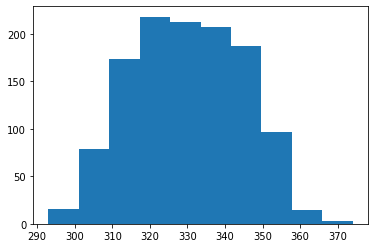

In [4]:
ARGMIN_DISTR = get_argmin_distr(data_path='./data/na62_11_pulses.txt')
plt.hist(ARGMIN_DISTR)
plt.show()

In [5]:
def prepare_data(X_origin, y_origin, tau_range, alpha_range, data_size=1000, to_print=False,\
                                                                         start_point=70, end_point=950):
    pos_size = int(data_size/2)
    neg_size = data_size - pos_size
    
    X = []
    y = []
    for i in range(data_size):
        alpha = random.choice(alpha_range)
        tau = random.choice(tau_range)
        
        if i < pos_size:
#             X.append(random.choice(X_one_signal))
            X.append(generate_multi_signal(X_origin, y_origin, tau, alpha,\
                                           argmin_distr=ARGMIN_DISTR)['first_impulse'][start_point:end_point])

            y.append(1)
        else:
            X.append(generate_multi_signal(X_origin, y_origin, tau, alpha,\
                                           argmin_distr=ARGMIN_DISTR)['multi_impulse'][start_point:end_point])
            y.append(0)
   
    X = np.array(X)
    y = np.array(y)
   
    if to_print:
        print("X shape:", X.shape)
        print("y shape:", y.shape)
    
    X, y = shuffle(X, y)

    return X, y

In [6]:
alpha_range = np.array([np.around(10**i, decimals=4) for i in np.arange(-3, 3.1, 0.1)])
tau_range = np.arange(-25, 25, 1)
X, y = prepare_data(X_origin, y_origin, tau_range, alpha_range, data_size=5000, to_print=True)

X shape: (5000, 880)
y shape: (5000,)


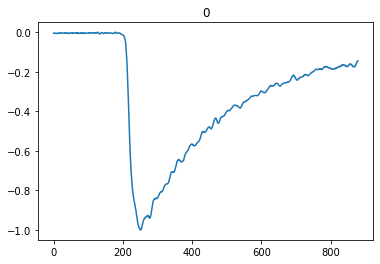

In [7]:
import random
i = random.choice(range(len(X)))
plt.title(str(y[i]))
plt.plot(X[i])
plt.show()

### Models

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier

In [9]:
freq_values = [1, 5, 10, 15, 25, 50, 60, 75, 85, 100]

In [10]:
def print_results(iter_num=200):
    global X_freq
    for freq in freq_values:
        X_freq = get_freq_data(X, freq=freq)

        best = fmin(
            fn=f,  # "Loss" function to minimize
            space=space,  # Hyperparameter space
            algo=tpe.suggest,  # Tree-structured Parzen Estimator (TPE)
            max_evals=iter_num  # Perform 100 trials
        )

        print('-----------------------------------------------------')
        print("Freq:", freq)
        print("X_freq shape:", X_freq.shape)
        print("Found minimum after %d trials:" %(iter_num))
        print(best)
        print('-----------------------------------------------------')

### Hyperopt

In [11]:
from hyperopt.pyll import scope as ho_scope
from hyperopt import fmin, tpe, hp

###### KNeighborsClassifier

In [12]:
def f(space):
        model = KNeighborsClassifier(n_neighbors=space['n_neighbors'], weights=space['weights'],\
                                     algorithm=space['algorithm'], leaf_size=space['leaf_size'], p=space['p'])
        scores = cross_validate(model, X_freq, y, scoring='f1', cv=5)
        return -scores['test_score'].mean()

space = {
        'n_neighbors': ho_scope.int(hp.quniform('n_neighbors', low=2, high=10, q=1)),
        'weights':  hp.choice('weights', ['uniform', 'distance']),
        'algorithm': hp.choice('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
        'leaf_size': ho_scope.int(hp.quniform('leaf_size', low=4, high=60, q=2)),
        'p': hp.choice('p', [1, 2])
}
    
global X_freq
print_results(iter_num=50)

100%|██████████| 50/50 [05:59<00:00,  7.19s/it, best loss: -0.49944250097474513]
-----------------------------------------------------
Freq: 1
X_freq shape: (5000, 880)
Found minimum after 50 trials:
{'algorithm': 3, 'leaf_size': 8.0, 'n_neighbors': 3.0, 'p': 1, 'weights': 1}
-----------------------------------------------------
100%|██████████| 50/50 [01:18<00:00,  1.57s/it, best loss: -0.5014112070836965]
-----------------------------------------------------
Freq: 5
X_freq shape: (5000, 176)
Found minimum after 50 trials:
{'algorithm': 1, 'leaf_size': 52.0, 'n_neighbors': 2.0, 'p': 1, 'weights': 1}
-----------------------------------------------------
100%|██████████| 50/50 [00:42<00:00,  1.19it/s, best loss: -0.514252148898676] 
-----------------------------------------------------
Freq: 10
X_freq shape: (5000, 88)
Found minimum after 50 trials:
{'algorithm': 1, 'leaf_size': 18.0, 'n_neighbors': 3.0, 'p': 1, 'weights': 1}
-----------------------------------------------------
100%|██

##### DecisionTreeClassifier

In [13]:
def f(space):
    model = DecisionTreeClassifier(max_depth=space['max_depth'], max_features=space['max_features'],\
                                  criterion=space['criterion'], min_samples_split=space['min_samples_split'],\
                                  min_samples_leaf=space['min_samples_leaf'], min_weight_fraction_leaf = space['min_weight_fraction_leaf'])
    scores = cross_validate(model, X_freq, y, scoring='f1', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'min_samples_split': ho_scope.int(hp.quniform('min_samples_split', low=2, high=10, q=1)),
    'min_samples_leaf':  ho_scope.int(hp.quniform('min_samples_leaf', low=1, high=10, q=1)),
    'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0, 0.5),
}

global X_freq
print_results()

100%|██████████| 200/200 [01:05<00:00,  3.03it/s, best loss: -0.6048152158096205]
-----------------------------------------------------
Freq: 1
X_freq shape: (5000, 880)
Found minimum after 200 trials:
{'criterion': 0, 'max_depth': 8, 'max_features': 0, 'min_samples_leaf': 9.0, 'min_samples_split': 6.0, 'min_weight_fraction_leaf': 0.09669755317264396}
-----------------------------------------------------
100%|██████████| 200/200 [00:28<00:00,  6.92it/s, best loss: -0.6015976297234159]
-----------------------------------------------------
Freq: 5
X_freq shape: (5000, 176)
Found minimum after 200 trials:
{'criterion': 1, 'max_depth': 12, 'max_features': 1, 'min_samples_leaf': 7.0, 'min_samples_split': 2.0, 'min_weight_fraction_leaf': 0.1932229501392354}
-----------------------------------------------------
100%|██████████| 200/200 [00:20<00:00,  9.82it/s, best loss: -0.602045727840559] 
-----------------------------------------------------
Freq: 10
X_freq shape: (5000, 88)
Found minimum 

##### RandomForest

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
def f(space):
    model = RandomForestClassifier(max_depth=space['max_depth'], max_features=space['max_features'],\
                                  criterion=space['criterion'], min_samples_split=space['min_samples_split'],\
                                  min_samples_leaf=space['min_samples_leaf'], min_weight_fraction_leaf = space['min_weight_fraction_leaf'],\
                                  verbose=0)
    scores = cross_validate(model, X_freq, y, scoring='f1', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'max_depth': hp.choice('max_depth', range(1,20)),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'min_samples_split': ho_scope.int(hp.quniform('min_samples_split', low=2, high=10, q=1)),
    'min_samples_leaf':  ho_scope.int(hp.quniform('min_samples_leaf', low=1, high=10, q=1)),
    'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0, 0.5),
}

global X_freq
print_results()

100%|██████████| 200/200 [07:17<00:00,  2.19s/it, best loss: -0.5988139703521217]
-----------------------------------------------------
Freq: 1
X_freq shape: (5000, 880)
Found minimum after 200 trials:
{'criterion': 1, 'max_depth': 16, 'max_features': 0, 'min_samples_leaf': 4.0, 'min_samples_split': 4.0, 'min_weight_fraction_leaf': 0.020520288218793627}
-----------------------------------------------------
100%|██████████| 200/200 [03:09<00:00,  1.05it/s, best loss: -0.5887150295952263]
-----------------------------------------------------
Freq: 5
X_freq shape: (5000, 176)
Found minimum after 200 trials:
{'criterion': 1, 'max_depth': 16, 'max_features': 0, 'min_samples_leaf': 10.0, 'min_samples_split': 3.0, 'min_weight_fraction_leaf': 0.07532931418243288}
-----------------------------------------------------
100%|██████████| 200/200 [02:05<00:00,  1.59it/s, best loss: -0.5874730506397492]
-----------------------------------------------------
Freq: 10
X_freq shape: (5000, 88)
Found mini

##### GaussianNB

In [16]:
def f(space):
    model = GaussianNB(var_smoothing=space['var_smoothing'])
    scores = cross_validate(model, X_freq, y, scoring='f1', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'var_smoothing': hp.loguniform('var_smoothing', low=np.log(1e-10), high=np.log(1e-7))
}

global X_freq
print_results()

100%|██████████| 200/200 [01:05<00:00,  3.07it/s, best loss: -0.4882049315330116]
-----------------------------------------------------
Freq: 1
X_freq shape: (5000, 880)
Found minimum after 200 trials:
{'var_smoothing': 8.100583294312482e-08}
-----------------------------------------------------
100%|██████████| 200/200 [00:12<00:00, 15.54it/s, best loss: -0.4866216824493363]
-----------------------------------------------------
Freq: 5
X_freq shape: (5000, 176)
Found minimum after 200 trials:
{'var_smoothing': 1.6022943050105917e-10}
-----------------------------------------------------
100%|██████████| 200/200 [00:07<00:00, 26.13it/s, best loss: -0.4820135689446802]
-----------------------------------------------------
Freq: 10
X_freq shape: (5000, 88)
Found minimum after 200 trials:
{'var_smoothing': 5.721182539749146e-08}
-----------------------------------------------------
100%|██████████| 200/200 [00:06<00:00, 30.82it/s, best loss: -0.4948786838973159]
--------------------------

##### SVC

In [ ]:
def f(space):
    model = SVC(C=space['C'], kernel=space['kernel'], degree=space['degree'], gamma=space['gamma'],\
               shrinking=space['shrinking'])
    scores = cross_validate(model, X_freq, y, scoring='f1', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'C': hp.loguniform('C', low=np.log(0.01), high=np.log(1)),
    'kernel': hp.choice('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
    'degree':  ho_scope.int(hp.quniform('degree', low=2, high=5, q=1)),
    'gamma':  hp.loguniform('gamma', low=np.log(0.001), high=np.log(100)),
    'shrinking': hp.choice('shrinking', [True, False])
}

global X_freq
print_results(iter_num=50)

100%|██████████| 50/50 [6:57:42<00:00, 501.25s/it, best loss: -0.7047457945562919]    
-----------------------------------------------------
Freq: 1
X_freq shape: (5000, 880)
Found minimum after 50 trials:
{'C': 0.9725968938886453, 'degree': 2.0, 'gamma': 0.2566760333046866, 'kernel': 2, 'shrinking': 0}
-----------------------------------------------------
100%|██████████| 50/50 [1:52:19<00:00, 134.78s/it, best loss: -0.6666666666666666] 
-----------------------------------------------------
Freq: 5
X_freq shape: (5000, 176)
Found minimum after 50 trials:
{'C': 0.01038270074688483, 'degree': 4.0, 'gamma': 52.03531554151558, 'kernel': 3, 'shrinking': 0}
-----------------------------------------------------
  0%|          | 0/50 [00:00<?, ?it/s, best loss: ?]

##### PassiveAggressiveClassifier

In [12]:
def f(space):
    model = PassiveAggressiveClassifier(C=space['C'], fit_intercept=space['fit_intercept'])
    scores = cross_validate(model, X_freq, y, scoring='f1', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'C': hp.loguniform('C', low=np.log(0.01), high=np.log(1)),
    'fit_intercept': hp.choice('fit_intercept', [True, False]),
}

global X_freq
print_results()

  0%|          | 0/200 [00:00<?, ?it/s, best loss: ?]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  0%|          | 1/200 [00:00<02:10,  1.53it/s, best loss: -0.0]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



  1%|          | 2/200 [00:01<02:00,  1.65it/s, best loss: -0.13333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  2%|▏         | 3/200 [00:01<02:03,  1.59it/s, best loss: -0.13333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



  2%|▏         | 4/200 [00:02<01:58,  1.66it/s, best loss: -0.4]                

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  2%|▎         | 5/200 [00:02<01:58,  1.64it/s, best loss: -0.4]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



  3%|▎         | 6/200 [00:03<02:05,  1.55it/s, best loss: -0.4]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



  4%|▎         | 7/200 [00:04<02:00,  1.61it/s, best loss: -0.4]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



  4%|▍         | 8/200 [00:04<02:02,  1.57it/s, best loss: -0.4]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



  4%|▍         | 9/200 [00:05<02:05,  1.52it/s, best loss: -0.530502384776711]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



  5%|▌         | 10/200 [00:06<02:00,  1.58it/s, best loss: -0.530502384776711]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



  6%|▌         | 11/200 [00:07<02:13,  1.42it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



  6%|▌         | 12/200 [00:07<02:09,  1.45it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



  7%|▋         | 14/200 [00:09<02:16,  1.36it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



  8%|▊         | 15/200 [00:09<02:07,  1.46it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



  8%|▊         | 16/200 [00:10<02:01,  1.51it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



  8%|▊         | 17/200 [00:11<01:59,  1.53it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



  9%|▉         | 18/200 [00:11<01:55,  1.58it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 10%|▉         | 19/200 [00:12<01:56,  1.56it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 10%|█         | 20/200 [00:13<01:54,  1.57it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 10%|█         | 21/200 [00:13<01:56,  1.53it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 11%|█         | 22/200 [00:14<01:58,  1.51it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 12%|█▏        | 23/200 [00:15<02:01,  1.46it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 12%|█▏        | 24/200 [00:15<01:59,  1.48it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 12%|█▎        | 25/200 [00:16<01:52,  1.56it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 13%|█▎        | 26/200 [00:16<01:51,  1.56it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 14%|█▎        | 27/200 [00:17<01:46,  1.62it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 14%|█▍        | 28/200 [00:18<01:49,  1.57it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 14%|█▍        | 29/200 [00:18<01:51,  1.54it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 15%|█▌        | 30/200 [00:19<01:53,  1.49it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 16%|█▌        | 31/200 [00:20<01:56,  1.45it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 16%|█▌        | 32/200 [00:20<01:47,  1.57it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 16%|█▋        | 33/200 [00:21<01:42,  1.63it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 17%|█▋        | 34/200 [00:22<01:57,  1.41it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 18%|█▊        | 35/200 [00:22<01:50,  1.49it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 18%|█▊        | 36/200 [00:23<01:49,  1.50it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 18%|█▊        | 37/200 [00:24<01:40,  1.61it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 19%|█▉        | 38/200 [00:24<01:49,  1.47it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 20%|█▉        | 39/200 [00:25<01:49,  1.47it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 20%|██        | 40/200 [00:26<01:47,  1.49it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 20%|██        | 41/200 [00:26<01:39,  1.59it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 21%|██        | 42/200 [00:27<01:45,  1.50it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 22%|██▏       | 43/200 [00:28<01:47,  1.46it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 22%|██▏       | 44/200 [00:29<01:50,  1.42it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 22%|██▎       | 45/200 [00:29<01:48,  1.43it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 23%|██▎       | 46/200 [00:30<01:47,  1.43it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 24%|██▍       | 48/200 [00:31<01:47,  1.41it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 24%|██▍       | 49/200 [00:32<01:44,  1.44it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 25%|██▌       | 50/200 [00:33<01:42,  1.46it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 26%|██▌       | 51/200 [00:33<01:39,  1.50it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 26%|██▌       | 52/200 [00:34<01:36,  1.53it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 26%|██▋       | 53/200 [00:35<01:41,  1.45it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 28%|██▊       | 56/200 [00:37<01:33,  1.54it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 28%|██▊       | 57/200 [00:37<01:30,  1.58it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 29%|██▉       | 58/200 [00:38<01:29,  1.59it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 30%|██▉       | 59/200 [00:38<01:26,  1.63it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 30%|███       | 60/200 [00:39<01:26,  1.62it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 30%|███       | 61/200 [00:40<01:22,  1.68it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 31%|███       | 62/200 [00:40<01:30,  1.52it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 32%|███▏      | 63/200 [00:41<01:32,  1.47it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 32%|███▏      | 64/200 [00:42<01:32,  1.47it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 32%|███▎      | 65/200 [00:43<01:30,  1.49it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 33%|███▎      | 66/200 [00:43<01:35,  1.40it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 34%|███▎      | 67/200 [00:44<01:32,  1.44it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 34%|███▍      | 68/200 [00:45<01:32,  1.42it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 34%|███▍      | 69/200 [00:45<01:33,  1.41it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 35%|███▌      | 70/200 [00:46<01:33,  1.39it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 36%|███▌      | 71/200 [00:47<01:31,  1.41it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 36%|███▌      | 72/200 [00:47<01:25,  1.49it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 36%|███▋      | 73/200 [00:48<01:29,  1.42it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 37%|███▋      | 74/200 [00:49<01:22,  1.52it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 38%|███▊      | 75/200 [00:49<01:21,  1.53it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 38%|███▊      | 76/200 [00:50<01:20,  1.54it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 38%|███▊      | 77/200 [00:51<01:20,  1.53it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 39%|███▉      | 78/200 [00:51<01:16,  1.60it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 40%|███▉      | 79/200 [00:52<01:15,  1.60it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 40%|████      | 80/200 [00:53<01:15,  1.59it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 40%|████      | 81/200 [00:53<01:14,  1.60it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 41%|████      | 82/200 [00:54<01:12,  1.64it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 42%|████▏     | 84/200 [00:55<01:12,  1.61it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 42%|████▎     | 85/200 [00:56<01:14,  1.53it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 43%|████▎     | 86/200 [00:56<01:13,  1.55it/s, best loss: -0.6663106364040943]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 44%|████▍     | 88/200 [00:58<01:12,  1.55it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 44%|████▍     | 89/200 [00:58<01:09,  1.60it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 45%|████▌     | 90/200 [00:59<01:07,  1.63it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 46%|████▌     | 91/200 [01:00<01:11,  1.54it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 46%|████▌     | 92/200 [01:00<01:08,  1.57it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 46%|████▋     | 93/200 [01:01<01:04,  1.65it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 48%|████▊     | 95/200 [01:02<01:09,  1.51it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 48%|████▊     | 96/200 [01:03<01:08,  1.51it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 48%|████▊     | 97/200 [01:03<01:06,  1.55it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 49%|████▉     | 98/200 [01:04<01:09,  1.47it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 50%|████▉     | 99/200 [01:05<01:08,  1.48it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 50%|█████     | 100/200 [01:05<01:04,  1.56it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 50%|█████     | 101/200 [01:06<01:03,  1.57it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 51%|█████     | 102/200 [01:07<00:59,  1.64it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 52%|█████▏    | 103/200 [01:07<00:58,  1.66it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 52%|█████▏    | 104/200 [01:08<01:02,  1.52it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 52%|█████▎    | 105/200 [01:09<01:02,  1.53it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 53%|█████▎    | 106/200 [01:09<00:58,  1.60it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 54%|█████▎    | 107/200 [01:10<00:58,  1.59it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 54%|█████▍    | 108/200 [01:10<00:57,  1.61it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 55%|█████▍    | 109/200 [01:11<00:58,  1.57it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 55%|█████▌    | 110/200 [01:12<00:57,  1.57it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 56%|█████▌    | 111/200 [01:12<00:54,  1.63it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 56%|█████▌    | 112/200 [01:13<00:52,  1.69it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 56%|█████▋    | 113/200 [01:13<00:51,  1.69it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 57%|█████▋    | 114/200 [01:14<00:50,  1.69it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 57%|█████▊    | 115/200 [01:15<00:49,  1.73it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 58%|█████▊    | 116/200 [01:15<00:49,  1.69it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 58%|█████▊    | 117/200 [01:16<00:50,  1.64it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 59%|█████▉    | 118/200 [01:16<00:51,  1.59it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 60%|█████▉    | 119/200 [01:17<00:50,  1.60it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 60%|██████    | 120/200 [01:18<00:52,  1.51it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 60%|██████    | 121/200 [01:18<00:50,  1.58it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 61%|██████    | 122/200 [01:19<00:48,  1.61it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 62%|██████▏   | 123/200 [01:20<00:46,  1.67it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 62%|██████▏   | 124/200 [01:20<00:44,  1.72it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 62%|██████▎   | 125/200 [01:21<00:41,  1.79it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 63%|██████▎   | 126/200 [01:21<00:43,  1.71it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 64%|██████▎   | 127/200 [01:22<00:43,  1.66it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 64%|██████▍   | 128/200 [01:23<00:44,  1.61it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 64%|██████▍   | 129/200 [01:23<00:49,  1.44it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 65%|██████▌   | 130/200 [01:24<00:47,  1.49it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 66%|██████▌   | 131/200 [01:25<00:44,  1.54it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 66%|██████▌   | 132/200 [01:25<00:44,  1.53it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 66%|██████▋   | 133/200 [01:26<00:42,  1.58it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 67%|██████▋   | 134/200 [01:27<00:43,  1.53it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 68%|██████▊   | 135/200 [01:27<00:43,  1.48it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 68%|██████▊   | 136/200 [01:28<00:42,  1.51it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 69%|██████▉   | 138/200 [01:29<00:41,  1.51it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 70%|██████▉   | 139/200 [01:30<00:39,  1.56it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 70%|███████   | 140/200 [01:30<00:36,  1.64it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 70%|███████   | 141/200 [01:31<00:36,  1.64it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 71%|███████   | 142/200 [01:32<00:36,  1.61it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 72%|███████▏  | 143/200 [01:32<00:35,  1.63it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 72%|███████▎  | 145/200 [01:34<00:35,  1.56it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 73%|███████▎  | 146/200 [01:34<00:36,  1.49it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 74%|███████▍  | 148/200 [01:36<00:33,  1.54it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 74%|███████▍  | 149/200 [01:36<00:32,  1.58it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 75%|███████▌  | 150/200 [01:37<00:31,  1.59it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 76%|███████▌  | 151/200 [01:37<00:29,  1.67it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 76%|███████▌  | 152/200 [01:38<00:29,  1.61it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 76%|███████▋  | 153/200 [01:39<00:30,  1.54it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 77%|███████▋  | 154/200 [01:39<00:29,  1.58it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 78%|███████▊  | 155/200 [01:40<00:29,  1.54it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 78%|███████▊  | 156/200 [01:41<00:30,  1.44it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 79%|███████▉  | 158/200 [01:42<00:28,  1.49it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 80%|███████▉  | 159/200 [01:43<00:27,  1.47it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 80%|████████  | 160/200 [01:43<00:26,  1.50it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 80%|████████  | 161/200 [01:44<00:26,  1.49it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 81%|████████  | 162/200 [01:45<00:26,  1.45it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 82%|████████▏ | 163/200 [01:45<00:22,  1.63it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 82%|████████▎ | 165/200 [01:47<00:21,  1.61it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 83%|████████▎ | 166/200 [01:47<00:20,  1.68it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 84%|████████▎ | 167/200 [01:48<00:20,  1.63it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 84%|████████▍ | 168/200 [01:49<00:21,  1.47it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 84%|████████▍ | 169/200 [01:49<00:22,  1.37it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 85%|████████▌ | 170/200 [01:50<00:20,  1.47it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 86%|████████▌ | 171/200 [01:51<00:19,  1.47it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 86%|████████▌ | 172/200 [01:51<00:19,  1.46it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 86%|████████▋ | 173/200 [01:52<00:18,  1.50it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 87%|████████▋ | 174/200 [01:53<00:17,  1.53it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 88%|████████▊ | 175/200 [01:53<00:16,  1.50it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 88%|████████▊ | 176/200 [01:54<00:15,  1.58it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 88%|████████▊ | 177/200 [01:54<00:14,  1.56it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 89%|████████▉ | 178/200 [01:55<00:14,  1.54it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 90%|████████▉ | 179/200 [01:56<00:12,  1.65it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 90%|█████████ | 180/200 [01:56<00:12,  1.62it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 90%|█████████ | 181/200 [01:57<00:12,  1.55it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 91%|█████████ | 182/200 [01:58<00:11,  1.55it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 92%|█████████▏| 183/200 [01:58<00:11,  1.54it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 92%|█████████▏| 184/200 [01:59<00:10,  1.56it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 92%|█████████▎| 185/200 [02:00<00:09,  1.53it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 93%|█████████▎| 186/200 [02:00<00:09,  1.51it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 94%|█████████▎| 187/200 [02:01<00:08,  1.61it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 94%|█████████▍| 188/200 [02:01<00:07,  1.59it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 96%|█████████▌| 191/200 [02:03<00:05,  1.70it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 96%|█████████▌| 192/200 [02:04<00:05,  1.55it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 96%|█████████▋| 193/200 [02:05<00:05,  1.39it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 97%|█████████▋| 194/200 [02:05<00:03,  1.53it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 98%|█████████▊| 195/200 [02:06<00:03,  1.59it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 98%|█████████▊| 196/200 [02:07<00:02,  1.60it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 98%|█████████▊| 197/200 [02:07<00:01,  1.54it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 99%|█████████▉| 198/200 [02:08<00:01,  1.49it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



100%|█████████▉| 199/200 [02:09<00:00,  1.49it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



100%|██████████| 200/200 [02:09<00:00,  1.54it/s, best loss: -0.6666666666666666]
-----------------------------------------------------
Freq: 1
X_freq shape: (5000, 880)
Found minimum after 200 trials:
{'C': 0.09606937087264018, 'fit_intercept': 0}
-----------------------------------------------------
  0%|          | 1/200 [00:00<00:30,  6.50it/s, best loss: -0.39511811142245923]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



  1%|          | 2/200 [00:00<00:30,  6.55it/s, best loss: -0.39511811142245923]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  2%|▏         | 3/200 [00:00<00:33,  5.82it/s, best loss: -0.39511811142245923]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



  2%|▎         | 5/200 [00:00<00:38,  5.08it/s, best loss: -0.5729807670005428] 

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  3%|▎         | 6/200 [00:01<00:37,  5.23it/s, best loss: -0.5729807670005428]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



  4%|▍         | 9/200 [00:01<00:32,  5.87it/s, best loss: -0.5729807670005428]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  5%|▌         | 10/200 [00:01<00:30,  6.25it/s, best loss: -0.5729807670005428]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  6%|▌         | 12/200 [00:02<00:30,  6.13it/s, best loss: -0.5729807670005428]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  7%|▋         | 14/200 [00:02<00:31,  5.99it/s, best loss: -0.5729807670005428]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  8%|▊         | 16/200 [00:02<00:27,  6.75it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 10%|▉         | 19/200 [00:03<00:25,  7.17it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 10%|█         | 20/200 [00:03<00:27,  6.66it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 11%|█         | 22/200 [00:03<00:27,  6.39it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 12%|█▏        | 23/200 [00:03<00:33,  5.28it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 13%|█▎        | 26/200 [00:04<00:34,  5.06it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 14%|█▍        | 28/200 [00:04<00:29,  5.81it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 14%|█▍        | 29/200 [00:05<00:28,  5.92it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 16%|█▌        | 31/200 [00:05<00:28,  5.96it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 16%|█▋        | 33/200 [00:05<00:26,  6.42it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 17%|█▋        | 34/200 [00:05<00:24,  6.75it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 18%|█▊        | 36/200 [00:06<00:25,  6.42it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 19%|█▉        | 38/200 [00:06<00:24,  6.75it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 20%|█▉        | 39/200 [00:06<00:29,  5.45it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 20%|██        | 40/200 [00:06<00:32,  4.98it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 20%|██        | 41/200 [00:07<00:30,  5.21it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 21%|██        | 42/200 [00:07<00:29,  5.44it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 22%|██▏       | 44/200 [00:07<00:35,  4.39it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 22%|██▎       | 45/200 [00:07<00:35,  4.41it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 23%|██▎       | 46/200 [00:08<00:29,  5.15it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 24%|██▍       | 48/200 [00:08<00:30,  4.92it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 24%|██▍       | 49/200 [00:08<00:31,  4.80it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 25%|██▌       | 50/200 [00:09<00:34,  4.39it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 26%|██▌       | 51/200 [00:09<00:30,  4.95it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 27%|██▋       | 54/200 [00:09<00:26,  5.50it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 28%|██▊       | 56/200 [00:09<00:23,  6.02it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 28%|██▊       | 57/200 [00:10<00:24,  5.72it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 30%|██▉       | 59/200 [00:10<00:22,  6.38it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 30%|███       | 60/200 [00:10<00:21,  6.54it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 31%|███       | 62/200 [00:10<00:20,  6.68it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 32%|███▏      | 63/200 [00:11<00:22,  5.96it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 32%|███▎      | 65/200 [00:11<00:19,  6.80it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 33%|███▎      | 66/200 [00:11<00:18,  7.12it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 34%|███▍      | 68/200 [00:11<00:19,  6.89it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 35%|███▌      | 70/200 [00:12<00:19,  6.66it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 36%|███▌      | 71/200 [00:12<00:21,  5.92it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 36%|███▌      | 72/200 [00:12<00:22,  5.76it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 37%|███▋      | 74/200 [00:12<00:22,  5.66it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 38%|███▊      | 76/200 [00:13<00:18,  6.77it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 39%|███▉      | 78/200 [00:13<00:20,  5.82it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 40%|████      | 80/200 [00:13<00:18,  6.41it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 40%|████      | 81/200 [00:14<00:23,  5.08it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 41%|████      | 82/200 [00:14<00:24,  4.75it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 42%|████▏     | 83/200 [00:14<00:29,  3.97it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 42%|████▏     | 84/200 [00:14<00:24,  4.71it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 43%|████▎     | 86/200 [00:15<00:20,  5.66it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 44%|████▍     | 89/200 [00:15<00:18,  6.12it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 46%|████▌     | 91/200 [00:16<00:22,  4.94it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 46%|████▌     | 92/200 [00:16<00:23,  4.68it/s, best loss: -0.6427888533216856]


/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 46%|████▋     | 93/200 [00:16<00:24,  4.37it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 47%|████▋     | 94/200 [00:16<00:23,  4.47it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 48%|████▊     | 95/200 [00:16<00:20,  5.09it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 48%|████▊     | 97/200 [00:17<00:20,  4.91it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 49%|████▉     | 98/200 [00:17<00:25,  3.96it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 50%|████▉     | 99/200 [00:17<00:27,  3.72it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 50%|█████     | 100/200 [00:18<00:25,  3.90it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 51%|█████     | 102/200 [00:18<00:19,  4.94it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 52%|█████▏    | 103/200 [00:18<00:18,  5.37it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 52%|█████▏    | 104/200 [00:18<00:17,  5.49it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 53%|█████▎    | 106/200 [00:19<00:15,  6.19it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 54%|█████▎    | 107/200 [00:19<00:14,  6.55it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 55%|█████▍    | 109/200 [00:19<00:14,  6.21it/s, best loss: -0.6427888533216856]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 56%|█████▌    | 111/200 [00:19<00:15,  5.62it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 56%|█████▌    | 112/200 [00:20<00:16,  5.38it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 56%|█████▋    | 113/200 [00:20<00:15,  5.65it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 57%|█████▊    | 115/200 [00:20<00:14,  5.80it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 58%|█████▊    | 116/200 [00:20<00:14,  5.81it/s, best loss: -0.6585558734781991]


/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 59%|█████▉    | 118/200 [00:21<00:12,  6.37it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 60%|██████    | 120/200 [00:21<00:12,  6.25it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 60%|██████    | 121/200 [00:21<00:12,  6.12it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 62%|██████▏   | 123/200 [00:21<00:11,  6.52it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 62%|██████▏   | 124/200 [00:22<00:12,  6.32it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 63%|██████▎   | 126/200 [00:22<00:11,  6.30it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 64%|██████▎   | 127/200 [00:22<00:11,  6.60it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 64%|██████▍   | 129/200 [00:22<00:12,  5.84it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 65%|██████▌   | 130/200 [00:23<00:12,  5.81it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 66%|██████▌   | 132/200 [00:23<00:10,  6.26it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 67%|██████▋   | 134/200 [00:23<00:09,  6.61it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 68%|██████▊   | 135/200 [00:23<00:09,  7.19it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 69%|██████▉   | 138/200 [00:24<00:09,  6.63it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 70%|███████   | 140/200 [00:24<00:08,  6.85it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 71%|███████   | 142/200 [00:24<00:08,  7.06it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 72%|███████▏  | 144/200 [00:25<00:08,  6.27it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 74%|███████▎  | 147/200 [00:25<00:08,  6.30it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 74%|███████▍  | 148/200 [00:25<00:08,  6.43it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 75%|███████▌  | 150/200 [00:26<00:07,  6.79it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 76%|███████▌  | 151/200 [00:26<00:07,  6.74it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 76%|███████▋  | 153/200 [00:26<00:07,  6.05it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 78%|███████▊  | 155/200 [00:27<00:08,  5.05it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 78%|███████▊  | 156/200 [00:27<00:08,  4.98it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 79%|███████▉  | 158/200 [00:27<00:06,  6.01it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 80%|███████▉  | 159/200 [00:27<00:06,  6.44it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 80%|████████  | 161/200 [00:27<00:06,  6.34it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 81%|████████  | 162/200 [00:28<00:06,  6.33it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 82%|████████▏ | 164/200 [00:28<00:05,  6.30it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 82%|████████▎ | 165/200 [00:28<00:05,  5.96it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 84%|████████▎ | 167/200 [00:28<00:05,  6.31it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 84%|████████▍ | 169/200 [00:29<00:05,  6.17it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 85%|████████▌ | 170/200 [00:29<00:05,  5.68it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 86%|████████▌ | 171/200 [00:29<00:05,  5.67it/s, best loss: -0.6585558734781991]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 86%|████████▋ | 173/200 [00:29<00:04,  6.03it/s, best loss: -0.6663994655978623]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 87%|████████▋ | 174/200 [00:30<00:03,  6.62it/s, best loss: -0.6663994655978623]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 88%|████████▊ | 177/200 [00:30<00:03,  6.66it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 89%|████████▉ | 178/200 [00:30<00:03,  6.50it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 90%|████████▉ | 179/200 [00:30<00:03,  5.99it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 90%|█████████ | 180/200 [00:31<00:04,  4.86it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 91%|█████████ | 182/200 [00:31<00:03,  5.61it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 92%|█████████▏| 184/200 [00:31<00:02,  6.13it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 92%|█████████▎| 185/200 [00:31<00:02,  6.23it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 93%|█████████▎| 186/200 [00:32<00:02,  6.25it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 94%|█████████▎| 187/200 [00:32<00:02,  6.17it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 94%|█████████▍| 188/200 [00:32<00:02,  5.52it/s, best loss: -0.6666666666666666]


/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 94%|█████████▍| 189/200 [00:32<00:02,  4.94it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 95%|█████████▌| 190/200 [00:32<00:01,  5.08it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 96%|█████████▌| 191/200 [00:33<00:01,  5.27it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 96%|█████████▋| 193/200 [00:33<00:01,  3.84it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 98%|█████████▊| 195/200 [00:34<00:01,  4.24it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 98%|█████████▊| 196/200 [00:34<00:01,  3.99it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 99%|█████████▉| 198/200 [00:34<00:00,  5.24it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

100%|██████████| 200/200 [00:35<00:00,  5.71it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)




-----------------------------------------------------
Freq: 5
X_freq shape: (5000, 176)
Found minimum after 200 trials:
{'C': 0.7232433580937414, 'fit_intercept': 1}
-----------------------------------------------------
  1%|          | 2/200 [00:00<00:16, 12.26it/s, best loss: -0.40088417681591126]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  2%|▏         | 4/200 [00:00<00:16, 11.70it/s, best loss: -0.40088417681591126]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  4%|▎         | 7/200 [00:00<00:18, 10.65it/s, best loss: -0.40088417681591126]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  4%|▍         | 8/200 [00:00<00:19,  9.67it/s, best loss: -0.40088417681591126]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  6%|▌         | 12/200 [00:01<00:17, 10.56it/s, best loss: -0.5198917900886545]


/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



  7%|▋         | 14/200 [00:01<00:17, 10.47it/s, best loss: -0.5246290801186942]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



  8%|▊         | 16/200 [00:01<00:18,  9.72it/s, best loss: -0.5246290801186942]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  9%|▉         | 18/200 [00:01<00:17, 10.41it/s, best loss: -0.5246290801186942]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 10%|█         | 20/200 [00:01<00:17, 10.18it/s, best loss: -0.665314401622718] 

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 11%|█         | 22/200 [00:02<00:17, 10.02it/s, best loss: -0.665314401622718]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 12%|█▎        | 25/200 [00:02<00:20,  8.72it/s, best loss: -0.665314401622718]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 14%|█▎        | 27/200 [00:02<00:23,  7.31it/s, best loss: -0.665314401622718]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 14%|█▍        | 28/200 [00:02<00:21,  7.85it/s, best loss: -0.665314401622718]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 16%|█▌        | 32/200 [00:03<00:18,  9.00it/s, best loss: -0.665314401622718]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 16%|█▋        | 33/200 [00:03<00:18,  9.17it/s, best loss: -0.665314401622718]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 18%|█▊        | 35/200 [00:03<00:18,  8.72it/s, best loss: -0.665314401622718]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 18%|█▊        | 36/200 [00:03<00:27,  5.87it/s, best loss: -0.665314401622718]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 19%|█▉        | 38/200 [00:04<00:28,  5.75it/s, best loss: -0.665314401622718]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 20%|█▉        | 39/200 [00:04<00:28,  5.75it/s, best loss: -0.665314401622718]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 20%|██        | 40/200 [00:04<00:27,  5.83it/s, best loss: -0.665314401622718]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 21%|██        | 42/200 [00:04<00:23,  6.84it/s, best loss: -0.665314401622718]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 22%|██▎       | 45/200 [00:05<00:23,  6.74it/s, best loss: -0.665314401622718]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 23%|██▎       | 46/200 [00:05<00:21,  7.31it/s, best loss: -0.665314401622718]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 25%|██▌       | 50/200 [00:05<00:16,  8.96it/s, best loss: -0.665314401622718]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 26%|██▌       | 52/200 [00:05<00:16,  9.23it/s, best loss: -0.665314401622718]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 27%|██▋       | 54/200 [00:06<00:14, 10.13it/s, best loss: -0.665314401622718]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 28%|██▊       | 56/200 [00:06<00:14, 10.17it/s, best loss: -0.665314401622718]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 29%|██▉       | 58/200 [00:06<00:14, 10.06it/s, best loss: -0.665314401622718]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 31%|███       | 62/200 [00:06<00:13, 10.36it/s, best loss: -0.665314401622718]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 32%|███▏      | 64/200 [00:07<00:13, 10.01it/s, best loss: -0.665314401622718]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 34%|███▍      | 68/200 [00:07<00:12, 10.57it/s, best loss: -0.665314401622718]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 35%|███▌      | 70/200 [00:07<00:13,  9.77it/s, best loss: -0.665314401622718]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 36%|███▌      | 72/200 [00:07<00:12,  9.93it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 37%|███▋      | 74/200 [00:07<00:12, 10.23it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 39%|███▉      | 78/200 [00:08<00:11, 10.46it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 40%|████      | 80/200 [00:08<00:11, 10.02it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 41%|████      | 82/200 [00:08<00:11, 10.56it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 42%|████▏     | 84/200 [00:08<00:10, 10.80it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 43%|████▎     | 86/200 [00:09<00:10, 10.40it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 44%|████▍     | 88/200 [00:09<00:12,  8.74it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 46%|████▌     | 91/200 [00:09<00:11,  9.30it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 46%|████▋     | 93/200 [00:09<00:11,  9.52it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 48%|████▊     | 95/200 [00:10<00:12,  8.59it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 48%|████▊     | 97/200 [00:10<00:11,  9.10it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 50%|████▉     | 99/200 [00:10<00:10,  9.20it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 50%|█████     | 100/200 [00:10<00:11,  8.65it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 52%|█████▏    | 103/200 [00:11<00:10,  8.98it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 52%|█████▎    | 105/200 [00:11<00:10,  9.47it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 54%|█████▎    | 107/200 [00:11<00:09,  9.82it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 55%|█████▌    | 110/200 [00:11<00:09,  9.12it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 57%|█████▋    | 114/200 [00:12<00:10,  8.55it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 58%|█████▊    | 116/200 [00:12<00:09,  9.08it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 60%|██████    | 120/200 [00:12<00:08,  9.63it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 62%|██████▏   | 124/200 [00:13<00:07, 10.00it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 63%|██████▎   | 126/200 [00:13<00:06, 10.72it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 65%|██████▌   | 130/200 [00:13<00:06, 10.87it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 66%|██████▌   | 132/200 [00:13<00:06, 10.76it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 67%|██████▋   | 134/200 [00:14<00:06, 10.90it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 68%|██████▊   | 136/200 [00:14<00:05, 11.14it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 70%|███████   | 140/200 [00:14<00:06,  9.78it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 71%|███████   | 142/200 [00:14<00:05, 10.00it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 72%|███████▏  | 144/200 [00:15<00:05, 10.22it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 74%|███████▎  | 147/200 [00:15<00:05,  9.34it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 74%|███████▍  | 149/200 [00:15<00:05,  9.90it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 76%|███████▌  | 151/200 [00:15<00:06,  8.00it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 76%|███████▋  | 153/200 [00:16<00:06,  7.02it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 79%|███████▉  | 158/200 [00:16<00:05,  7.80it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 80%|███████▉  | 159/200 [00:16<00:05,  8.01it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 81%|████████  | 162/200 [00:17<00:04,  8.01it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 82%|████████▏ | 164/200 [00:17<00:04,  8.55it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 82%|████████▎ | 165/200 [00:17<00:03,  8.77it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 84%|████████▍ | 168/200 [00:18<00:04,  7.68it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 84%|████████▍ | 169/200 [00:18<00:04,  6.83it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 85%|████████▌ | 170/200 [00:18<00:04,  7.41it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 86%|████████▌ | 172/200 [00:18<00:03,  7.88it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 88%|████████▊ | 176/200 [00:18<00:02,  8.77it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 88%|████████▊ | 177/200 [00:19<00:02,  9.03it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 90%|████████▉ | 179/200 [00:19<00:02,  8.66it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 90%|█████████ | 181/200 [00:19<00:02,  7.17it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 92%|█████████▏| 184/200 [00:20<00:02,  7.20it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 92%|█████████▎| 185/200 [00:20<00:02,  7.11it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 94%|█████████▎| 187/200 [00:20<00:01,  8.02it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 95%|█████████▌| 190/200 [00:20<00:01,  7.97it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 96%|█████████▌| 192/200 [00:20<00:00,  8.53it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 97%|█████████▋| 194/200 [00:21<00:00,  8.77it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 99%|█████████▉| 198/200 [00:21<00:00,  9.99it/s, best loss: -0.6667556148543473]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

100%|██████████| 200/200 [00:21<00:00,  9.25it/s, best loss: -0.6667556148543473]
-----------------------------------------------------
Freq: 10
X_freq shape: (5000, 88)
Found minimum after 200 trials:
{'C': 0.14130229226935603, 'fit_intercept': 0}
-----------------------------------------------------
  0%|          | 0/200 [00:00<?, ?it/s, best loss: ?]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  1%|          | 2/200 [00:00<00:26,  7.45it/s, best loss: -0.3329549574715125]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  2%|▏         | 4/200 [00:00<00:24,  8.06it/s, best loss: -0.3329549574715125]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  2%|▎         | 5/200 [00:00<00:25,  7.76it/s, best loss: -0.3329549574715125]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  4%|▎         | 7/200 [00:00<00:22,  8.57it/s, best loss: -0.4]               

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  5%|▌         | 10/200 [00:01<00:21,  8.82it/s, best loss: -0.4]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  6%|▋         | 13/200 [00:01<00:19,  9.71it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  8%|▊         | 17/200 [00:01<00:15, 11.64it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 10%|█         | 21/200 [00:01<00:13, 12.80it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 12%|█▏        | 23/200 [00:02<00:14, 11.96it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 12%|█▎        | 25/200 [00:02<00:15, 11.33it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 14%|█▍        | 29/200 [00:02<00:13, 12.92it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 16%|█▌        | 31/200 [00:02<00:15, 10.83it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 16%|█▋        | 33/200 [00:03<00:15, 10.73it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 18%|█▊        | 37/200 [00:03<00:14, 11.02it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 20%|█▉        | 39/200 [00:03<00:18,  8.65it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 20%|██        | 41/200 [00:04<00:22,  6.93it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 21%|██        | 42/200 [00:04<00:25,  6.29it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 22%|██▏       | 43/200 [00:04<00:26,  6.03it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 23%|██▎       | 46/200 [00:04<00:22,  6.97it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 24%|██▍       | 49/200 [00:05<00:17,  8.63it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 26%|██▌       | 51/200 [00:05<00:15,  9.66it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 28%|██▊       | 55/200 [00:05<00:12, 11.39it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 28%|██▊       | 57/200 [00:05<00:12, 11.12it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 30%|██▉       | 59/200 [00:05<00:12, 11.36it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 32%|███▏      | 63/200 [00:06<00:11, 11.91it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 32%|███▎      | 65/200 [00:06<00:10, 12.32it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 34%|███▎      | 67/200 [00:06<00:10, 12.70it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 34%|███▍      | 69/200 [00:06<00:13,  9.51it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 36%|███▋      | 73/200 [00:07<00:11, 10.65it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 38%|███▊      | 75/200 [00:07<00:11, 11.07it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 40%|███▉      | 79/200 [00:07<00:10, 11.36it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 42%|████▏     | 83/200 [00:08<00:09, 11.72it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 42%|████▎     | 85/200 [00:08<00:09, 12.01it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 44%|████▎     | 87/200 [00:08<00:09, 12.28it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 44%|████▍     | 89/200 [00:08<00:09, 11.74it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 46%|████▋     | 93/200 [00:08<00:09, 11.77it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 48%|████▊     | 95/200 [00:09<00:09, 11.38it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 50%|████▉     | 99/200 [00:09<00:11,  8.80it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 52%|█████▏    | 103/200 [00:10<00:09, 10.14it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 52%|█████▎    | 105/200 [00:10<00:08, 10.76it/s, best loss: -0.6663983903420523]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 54%|█████▎    | 107/200 [00:10<00:08, 11.31it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 56%|█████▌    | 111/200 [00:10<00:07, 12.10it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 56%|█████▋    | 113/200 [00:10<00:07, 11.61it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 58%|█████▊    | 117/200 [00:11<00:07, 11.81it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 60%|█████▉    | 119/200 [00:11<00:06, 12.98it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 62%|██████▎   | 125/200 [00:11<00:05, 12.71it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 64%|██████▎   | 127/200 [00:11<00:05, 12.90it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 66%|██████▌   | 131/200 [00:12<00:05, 13.43it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 66%|██████▋   | 133/200 [00:12<00:04, 13.56it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 68%|██████▊   | 137/200 [00:12<00:04, 12.73it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 70%|██████▉   | 139/200 [00:12<00:04, 12.25it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 72%|███████▏  | 143/200 [00:13<00:04, 12.74it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 72%|███████▎  | 145/200 [00:13<00:04, 12.68it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 74%|███████▎  | 147/200 [00:13<00:04, 13.02it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 76%|███████▌  | 151/200 [00:13<00:03, 13.72it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 78%|███████▊  | 155/200 [00:14<00:03, 12.88it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 78%|███████▊  | 157/200 [00:14<00:03, 12.73it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 80%|████████  | 161/200 [00:14<00:02, 13.24it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 82%|████████▏ | 163/200 [00:14<00:03, 12.03it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 82%|████████▎ | 165/200 [00:14<00:02, 11.87it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 84%|████████▍ | 169/200 [00:15<00:02, 11.87it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 86%|████████▋ | 173/200 [00:15<00:02, 10.40it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 88%|████████▊ | 175/200 [00:15<00:02, 11.17it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 90%|████████▉ | 179/200 [00:16<00:01, 11.40it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 90%|█████████ | 181/200 [00:16<00:01, 11.37it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 92%|█████████▎| 185/200 [00:16<00:01,  9.70it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 94%|█████████▎| 187/200 [00:17<00:01,  8.70it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 94%|█████████▍| 189/200 [00:17<00:01,  8.92it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 95%|█████████▌| 190/200 [00:17<00:01,  9.19it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 97%|█████████▋| 194/200 [00:17<00:00, 10.35it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 98%|█████████▊| 196/200 [00:17<00:00, 10.82it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 99%|█████████▉| 198/200 [00:18<00:00, 11.21it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



100%|██████████| 200/200 [00:18<00:00, 10.93it/s, best loss: -0.6666666666666666]
-----------------------------------------------------
Freq: 15
X_freq shape: (5000, 58)
Found minimum after 200 trials:
{'C': 0.14591933716083283, 'fit_intercept': 1}
-----------------------------------------------------
  0%|          | 0/200 [00:00<?, ?it/s, best loss: ?]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  2%|▏         | 3/200 [00:00<00:19, 10.25it/s, best loss: -0.43507924783460294]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



  4%|▎         | 7/200 [00:00<00:16, 11.97it/s, best loss: -0.5332441471571906] 

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  6%|▋         | 13/200 [00:00<00:11, 15.87it/s, best loss: -0.5332441471571906]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  8%|▊         | 15/200 [00:01<00:11, 15.84it/s, best loss: -0.5332441471571906]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 10%|▉         | 19/200 [00:01<00:11, 15.27it/s, best loss: -0.5332441471571906]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 12%|█▏        | 23/200 [00:01<00:11, 16.04it/s, best loss: -0.5332441471571906]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 13%|█▎        | 26/200 [00:01<00:10, 17.24it/s, best loss: -0.5332441471571906]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 15%|█▌        | 30/200 [00:01<00:10, 16.58it/s, best loss: -0.5332441471571906]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 16%|█▌        | 32/200 [00:02<00:12, 13.67it/s, best loss: -0.5332441471571906]


/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'prec

 18%|█▊        | 36/200 [00:02<00:11, 14.27it/s, best loss: -0.5332441471571906]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 20%|██        | 40/200 [00:02<00:09, 16.04it/s, best loss: -0.5332441471571906]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 22%|██▏       | 44/200 [00:02<00:11, 14.04it/s, best loss: -0.6596336996336996]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 23%|██▎       | 46/200 [00:03<00:12, 12.54it/s, best loss: -0.6596336996336996]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 24%|██▍       | 48/200 [00:03<00:12, 11.73it/s, best loss: -0.6596336996336996]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 26%|██▌       | 52/200 [00:03<00:10, 13.68it/s, best loss: -0.6596336996336996]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 27%|██▋       | 54/200 [00:03<00:10, 14.39it/s, best loss: -0.6596336996336996]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 29%|██▉       | 58/200 [00:03<00:09, 15.78it/s, best loss: -0.6661322645290582]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 31%|███       | 62/200 [00:04<00:08, 15.84it/s, best loss: -0.6661322645290582]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 33%|███▎      | 66/200 [00:04<00:08, 16.48it/s, best loss: -0.6661322645290582]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 34%|███▍      | 68/200 [00:04<00:09, 13.92it/s, best loss: -0.6661322645290582]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 35%|███▌      | 70/200 [00:04<00:11, 11.78it/s, best loss: -0.6661322645290582]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 36%|███▌      | 72/200 [00:04<00:10, 12.27it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 38%|███▊      | 76/200 [00:05<00:10, 11.79it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 40%|████      | 80/200 [00:05<00:09, 13.09it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 43%|████▎     | 86/200 [00:05<00:07, 16.13it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 44%|████▍     | 88/200 [00:06<00:06, 16.21it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 46%|████▌     | 92/200 [00:06<00:06, 17.74it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 48%|████▊     | 96/200 [00:06<00:05, 17.57it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 50%|█████     | 100/200 [00:06<00:06, 16.26it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 51%|█████     | 102/200 [00:06<00:07, 13.78it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 53%|█████▎    | 106/200 [00:07<00:06, 14.82it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 55%|█████▌    | 110/200 [00:07<00:05, 16.12it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 56%|█████▌    | 112/200 [00:07<00:05, 16.12it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 57%|█████▋    | 114/200 [00:07<00:06, 13.75it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 59%|█████▉    | 118/200 [00:07<00:05, 14.72it/s, best loss: -0.6666666666666666]


/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 61%|██████    | 122/200 [00:08<00:04, 16.48it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 63%|██████▎   | 126/200 [00:08<00:04, 16.47it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 65%|██████▌   | 130/200 [00:08<00:04, 16.59it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 66%|██████▌   | 132/200 [00:08<00:04, 16.86it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 68%|██████▊   | 136/200 [00:09<00:03, 16.46it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 70%|███████   | 140/200 [00:09<00:03, 16.00it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 72%|███████▏  | 144/200 [00:09<00:03, 16.81it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 73%|███████▎  | 146/200 [00:09<00:03, 17.00it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 75%|███████▌  | 150/200 [00:09<00:03, 14.63it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 77%|███████▋  | 154/200 [00:10<00:02, 15.68it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 79%|███████▉  | 158/200 [00:10<00:02, 15.84it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 81%|████████  | 162/200 [00:10<00:02, 16.04it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 83%|████████▎ | 166/200 [00:10<00:02, 16.94it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 85%|████████▌ | 170/200 [00:11<00:01, 17.14it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 86%|████████▌ | 172/200 [00:11<00:01, 16.20it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 88%|████████▊ | 176/200 [00:11<00:01, 15.61it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 90%|█████████ | 180/200 [00:11<00:01, 16.64it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 92%|█████████▏| 184/200 [00:12<00:01, 14.86it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 93%|█████████▎| 186/200 [00:12<00:00, 15.64it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 95%|█████████▌| 190/200 [00:12<00:00, 15.63it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 96%|█████████▌| 192/200 [00:12<00:00, 15.85it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 98%|█████████▊| 195/200 [00:12<00:00, 16.58it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

100%|██████████| 200/200 [00:13<00:00, 15.16it/s, best loss: -0.6666666666666666]
-----------------------------------------------------
Freq: 25
X_freq shape: (5000, 35)
Found minimum after 200 trials:
{'C': 0.4172504415236293, 'fit_intercept': 1}
-----------------------------------------------------
  0%|          | 0/200 [00:00<?, ?it/s, best loss: ?]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  1%|          | 2/200 [00:00<00:11, 17.28it/s, best loss: -0.4000889481876807]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  4%|▎         | 7/200 [00:00<00:10, 18.48it/s, best loss: -0.5245431145431144]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  6%|▌         | 12/200 [00:00<00:09, 19.45it/s, best loss: -0.5245431145431144]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  8%|▊         | 17/200 [00:00<00:08, 20.61it/s, best loss: -0.5245431145431144]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 10%|█         | 20/200 [00:00<00:08, 21.51it/s, best loss: -0.5245431145431144]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 13%|█▎        | 26/200 [00:01<00:08, 21.59it/s, best loss: -0.6495393630112012]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 16%|█▌        | 32/200 [00:01<00:07, 22.26it/s, best loss: -0.6495393630112012]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 19%|█▉        | 38/200 [00:01<00:07, 22.05it/s, best loss: -0.6495393630112012]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 20%|██        | 41/200 [00:01<00:07, 19.99it/s, best loss: -0.6495393630112012]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 22%|██▏       | 44/200 [00:02<00:07, 20.14it/s, best loss: -0.6495393630112012]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 24%|██▍       | 49/200 [00:02<00:09, 15.72it/s, best loss: -0.6495393630112012]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 26%|██▌       | 51/200 [00:02<00:10, 14.51it/s, best loss: -0.6495393630112012]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 28%|██▊       | 56/200 [00:02<00:08, 16.09it/s, best loss: -0.6495393630112012]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 30%|██▉       | 59/200 [00:03<00:08, 17.44it/s, best loss: -0.6495393630112012]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 32%|███▎      | 65/200 [00:03<00:06, 19.33it/s, best loss: -0.6495393630112012]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 34%|███▍      | 68/200 [00:03<00:06, 19.47it/s, best loss: -0.6495393630112012]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 36%|███▋      | 73/200 [00:03<00:06, 18.85it/s, best loss: -0.6495393630112012]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 38%|███▊      | 76/200 [00:03<00:06, 19.58it/s, best loss: -0.6495393630112012]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 41%|████      | 82/200 [00:04<00:05, 20.55it/s, best loss: -0.665413870246085] 

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 42%|████▎     | 85/200 [00:04<00:05, 20.32it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 46%|████▌     | 91/200 [00:04<00:05, 19.89it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 48%|████▊     | 97/200 [00:04<00:04, 21.10it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 50%|█████     | 100/200 [00:05<00:05, 19.33it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 52%|█████▏    | 104/200 [00:05<00:06, 15.17it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 54%|█████▍    | 108/200 [00:05<00:05, 15.36it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 56%|█████▌    | 111/200 [00:05<00:05, 17.18it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 58%|█████▊    | 116/200 [00:06<00:04, 18.01it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 61%|██████    | 122/200 [00:06<00:04, 17.51it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 64%|██████▎   | 127/200 [00:06<00:03, 18.55it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 66%|██████▌   | 131/200 [00:06<00:03, 17.94it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 68%|██████▊   | 136/200 [00:07<00:03, 17.99it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 69%|██████▉   | 138/200 [00:07<00:03, 18.03it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 72%|███████▏  | 143/200 [00:07<00:03, 17.37it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 73%|███████▎  | 146/200 [00:07<00:02, 18.24it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 76%|███████▌  | 151/200 [00:07<00:02, 18.15it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 78%|███████▊  | 156/200 [00:08<00:02, 17.73it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 80%|███████▉  | 159/200 [00:08<00:02, 19.14it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 82%|████████▎ | 165/200 [00:08<00:01, 19.54it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 85%|████████▌ | 170/200 [00:08<00:01, 18.33it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 86%|████████▋ | 173/200 [00:09<00:01, 19.74it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 90%|████████▉ | 179/200 [00:09<00:00, 21.79it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 92%|█████████▎| 185/200 [00:09<00:00, 22.17it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 94%|█████████▍| 188/200 [00:09<00:00, 20.04it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 97%|█████████▋| 194/200 [00:10<00:00, 20.10it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 98%|█████████▊| 197/200 [00:10<00:00, 17.00it/s, best loss: -0.665413870246085]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

100%|██████████| 200/200 [00:10<00:00, 19.02it/s, best loss: -0.665413870246085]
-----------------------------------------------------
Freq: 50
X_freq shape: (5000, 17)
Found minimum after 200 trials:
{'C': 0.07285933459663858, 'fit_intercept': 1}
-----------------------------------------------------
  0%|          | 0/200 [00:00<?, ?it/s, best loss: ?]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  1%|          | 2/200 [00:00<00:10, 18.51it/s, best loss: -0.3630725863284002]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  4%|▎         | 7/200 [00:00<00:11, 16.26it/s, best loss: -0.5148342059336823]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  4%|▍         | 9/200 [00:00<00:12, 15.29it/s, best loss: -0.5148342059336823]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  7%|▋         | 14/200 [00:00<00:10, 17.51it/s, best loss: -0.5148342059336823]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 10%|▉         | 19/200 [00:01<00:09, 18.67it/s, best loss: -0.5148342059336823]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 10%|█         | 21/200 [00:01<00:10, 17.24it/s, best loss: -0.5148342059336823]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 13%|█▎        | 26/200 [00:01<00:10, 15.90it/s, best loss: -0.5148342059336823]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 16%|█▌        | 31/200 [00:01<00:09, 18.47it/s, best loss: -0.5148342059336823]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 18%|█▊        | 37/200 [00:02<00:08, 18.49it/s, best loss: -0.5310152990264256]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 20%|██        | 40/200 [00:02<00:08, 19.77it/s, best loss: -0.5310152990264256]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 22%|██▏       | 43/200 [00:02<00:09, 17.21it/s, best loss: -0.5310152990264256]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 24%|██▍       | 48/200 [00:02<00:08, 17.76it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 26%|██▌       | 51/200 [00:02<00:07, 18.65it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 28%|██▊       | 56/200 [00:03<00:07, 20.37it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 31%|███       | 62/200 [00:03<00:06, 21.96it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 32%|███▎      | 65/200 [00:03<00:05, 22.82it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 36%|███▌      | 71/200 [00:03<00:06, 20.64it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 37%|███▋      | 74/200 [00:03<00:05, 21.95it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 38%|███▊      | 77/200 [00:04<00:06, 19.07it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 42%|████▏     | 83/200 [00:04<00:06, 19.25it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 43%|████▎     | 86/200 [00:04<00:06, 18.58it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 45%|████▌     | 90/200 [00:04<00:06, 17.84it/s, best loss: -0.6277777777777778]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 48%|████▊     | 96/200 [00:05<00:05, 20.03it/s, best loss: -0.6277777777777778]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 51%|█████     | 102/200 [00:05<00:04, 22.17it/s, best loss: -0.6578469520103761]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 52%|█████▎    | 105/200 [00:05<00:04, 23.37it/s, best loss: -0.6578469520103761]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 54%|█████▍    | 108/200 [00:05<00:04, 22.12it/s, best loss: -0.6578469520103761]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 57%|█████▋    | 114/200 [00:05<00:04, 20.64it/s, best loss: -0.6578469520103761]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 60%|██████    | 120/200 [00:06<00:03, 22.67it/s, best loss: -0.6578469520103761]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 63%|██████▎   | 126/200 [00:06<00:03, 20.03it/s, best loss: -0.6578469520103761]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 66%|██████▌   | 132/200 [00:06<00:03, 20.93it/s, best loss: -0.665676344812064] 

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 68%|██████▊   | 135/200 [00:06<00:03, 21.43it/s, best loss: -0.665676344812064]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 70%|███████   | 141/200 [00:07<00:02, 22.25it/s, best loss: -0.665676344812064]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 72%|███████▏  | 144/200 [00:07<00:02, 20.36it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 75%|███████▌  | 150/200 [00:07<00:02, 21.20it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 78%|███████▊  | 156/200 [00:07<00:01, 23.07it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 81%|████████  | 162/200 [00:08<00:01, 22.09it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 82%|████████▎ | 165/200 [00:08<00:01, 20.89it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 84%|████████▍ | 168/200 [00:08<00:01, 20.85it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 86%|████████▋ | 173/200 [00:08<00:01, 19.39it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 90%|████████▉ | 179/200 [00:08<00:00, 21.07it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 91%|█████████ | 182/200 [00:09<00:00, 21.65it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 94%|█████████▍| 188/200 [00:09<00:00, 22.34it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 96%|█████████▌| 191/200 [00:09<00:00, 21.86it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 98%|█████████▊| 197/200 [00:09<00:00, 21.98it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

100%|██████████| 200/200 [00:09<00:00, 20.12it/s, best loss: -0.6666666666666666]
-----------------------------------------------------
Freq: 60
X_freq shape: (5000, 14)
Found minimum after 200 trials:
{'C': 0.8369142522415778, 'fit_intercept': 1}
-----------------------------------------------------
  0%|          | 0/200 [00:00<?, ?it/s, best loss: ?]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  4%|▎         | 7/200 [00:00<00:07, 26.88it/s, best loss: -0.40042877359178675]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  5%|▌         | 10/200 [00:00<00:08, 23.44it/s, best loss: -0.40042877359178675]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  8%|▊         | 15/200 [00:00<00:08, 23.08it/s, best loss: -0.4026742965763047] 

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 10%|█         | 21/200 [00:00<00:07, 25.27it/s, best loss: -0.5320386026035607]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 14%|█▎        | 27/200 [00:01<00:07, 22.72it/s, best loss: -0.5320386026035607]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 15%|█▌        | 30/200 [00:01<00:08, 19.84it/s, best loss: -0.6400366550541349]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 16%|█▋        | 33/200 [00:01<00:08, 19.09it/s, best loss: -0.6400366550541349]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 21%|██        | 42/200 [00:01<00:06, 23.28it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 22%|██▎       | 45/200 [00:02<00:07, 20.99it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 24%|██▍       | 48/200 [00:02<00:07, 19.08it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 26%|██▌       | 51/200 [00:02<00:08, 17.23it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 28%|██▊       | 57/200 [00:02<00:09, 15.83it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 30%|██▉       | 59/200 [00:02<00:08, 16.23it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 32%|███▏      | 64/200 [00:03<00:07, 18.22it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 35%|███▌      | 70/200 [00:03<00:06, 19.72it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 38%|███▊      | 76/200 [00:03<00:05, 23.01it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 41%|████      | 82/200 [00:03<00:04, 24.35it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 42%|████▎     | 85/200 [00:04<00:04, 24.03it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 46%|████▌     | 91/200 [00:04<00:04, 23.09it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 48%|████▊     | 97/200 [00:04<00:04, 23.79it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 50%|█████     | 100/200 [00:04<00:04, 21.91it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 53%|█████▎    | 106/200 [00:05<00:04, 22.08it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 56%|█████▌    | 112/200 [00:05<00:04, 21.62it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 57%|█████▊    | 115/200 [00:05<00:04, 19.11it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 58%|█████▊    | 117/200 [00:05<00:04, 17.12it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 60%|██████    | 121/200 [00:05<00:04, 16.96it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 62%|██████▏   | 123/200 [00:06<00:05, 14.72it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 64%|██████▎   | 127/200 [00:06<00:05, 13.86it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 64%|██████▍   | 129/200 [00:06<00:05, 13.36it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 67%|██████▋   | 134/200 [00:06<00:05, 12.67it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 70%|██████▉   | 139/200 [00:07<00:03, 15.50it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 70%|███████   | 141/200 [00:07<00:04, 14.37it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 72%|███████▎  | 145/200 [00:07<00:03, 14.06it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 74%|███████▎  | 147/200 [00:07<00:03, 13.80it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 74%|███████▍  | 149/200 [00:07<00:03, 13.10it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 78%|███████▊  | 156/200 [00:08<00:02, 15.11it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 80%|███████▉  | 159/200 [00:08<00:02, 16.76it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 82%|████████▏ | 164/200 [00:08<00:02, 16.27it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 83%|████████▎ | 166/200 [00:08<00:02, 15.65it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 86%|████████▋ | 173/200 [00:09<00:01, 17.66it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 88%|████████▊ | 176/200 [00:09<00:01, 18.65it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 90%|█████████ | 180/200 [00:09<00:01, 17.13it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 92%|█████████▏| 184/200 [00:09<00:00, 17.41it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 94%|█████████▍| 188/200 [00:10<00:00, 16.56it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 96%|█████████▋| 193/200 [00:10<00:00, 16.27it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 98%|█████████▊| 197/200 [00:10<00:00, 16.22it/s, best loss: -0.6656865721140566]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

100%|██████████| 200/200 [00:10<00:00, 18.33it/s, best loss: -0.6656865721140566]
-----------------------------------------------------
Freq: 75
X_freq shape: (5000, 12)
Found minimum after 200 trials:
{'C': 0.04184915638152027, 'fit_intercept': 1}
-----------------------------------------------------
  0%|          | 0/200 [00:00<?, ?it/s, best loss: ?]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  3%|▎         | 6/200 [00:00<00:10, 19.06it/s, best loss: -0.424273241454258]  

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  4%|▍         | 8/200 [00:00<00:10, 18.84it/s, best loss: -0.424273241454258]


/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'prec

  6%|▌         | 12/200 [00:00<00:12, 15.35it/s, best loss: -0.424273241454258]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  8%|▊         | 15/200 [00:00<00:10, 17.46it/s, best loss: -0.45294964028776974]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 11%|█         | 22/200 [00:01<00:09, 19.54it/s, best loss: -0.526999947154932]  

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 13%|█▎        | 26/200 [00:01<00:10, 16.24it/s, best loss: -0.526999947154932]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 15%|█▌        | 30/200 [00:01<00:11, 15.45it/s, best loss: -0.526999947154932]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 16%|█▌        | 32/200 [00:01<00:10, 15.57it/s, best loss: -0.526999947154932]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 19%|█▉        | 38/200 [00:02<00:09, 17.49it/s, best loss: -0.526999947154932]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 22%|██▏       | 43/200 [00:02<00:08, 19.29it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 23%|██▎       | 46/200 [00:02<00:07, 20.51it/s, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 26%|██▌       | 51/200 [00:02<00:07, 18.67it/s, best loss: -0.6081356998123945]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 28%|██▊       | 57/200 [00:02<00:06, 22.01it/s, best loss: -0.6081356998123945]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 32%|███▏      | 63/200 [00:03<00:05, 24.03it/s, best loss: -0.6081356998123945]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 34%|███▍      | 69/200 [00:03<00:05, 25.63it/s, best loss: -0.6081356998123945]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 36%|███▌      | 72/200 [00:03<00:05, 22.52it/s, best loss: -0.6081356998123945]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 38%|███▊      | 75/200 [00:03<00:06, 19.70it/s, best loss: -0.6081356998123945]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 40%|████      | 81/200 [00:04<00:05, 20.76it/s, best loss: -0.6081356998123945]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 42%|████▏     | 84/200 [00:04<00:05, 22.18it/s, best loss: -0.6081356998123945]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 44%|████▎     | 87/200 [00:04<00:05, 18.86it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 46%|████▋     | 93/200 [00:04<00:05, 20.21it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 50%|████▉     | 99/200 [00:04<00:04, 21.69it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 51%|█████     | 102/200 [00:05<00:04, 22.78it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 52%|█████▎    | 105/200 [00:05<00:04, 20.80it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 56%|█████▌    | 111/200 [00:05<00:04, 19.91it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 58%|█████▊    | 117/200 [00:05<00:03, 22.85it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 62%|██████▏   | 123/200 [00:06<00:03, 23.31it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 63%|██████▎   | 126/200 [00:06<00:03, 24.18it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 66%|██████▌   | 132/200 [00:06<00:03, 21.49it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 68%|██████▊   | 135/200 [00:06<00:03, 20.44it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 69%|██████▉   | 138/200 [00:06<00:03, 18.34it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 72%|███████▏  | 143/200 [00:07<00:03, 15.47it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 74%|███████▍  | 148/200 [00:07<00:02, 18.20it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 76%|███████▌  | 151/200 [00:07<00:02, 18.43it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 78%|███████▊  | 156/200 [00:07<00:02, 18.72it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 81%|████████  | 162/200 [00:08<00:01, 20.91it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 82%|████████▎ | 165/200 [00:08<00:01, 22.72it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 84%|████████▍ | 168/200 [00:08<00:01, 21.90it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 87%|████████▋ | 174/200 [00:08<00:01, 18.19it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 89%|████████▉ | 178/200 [00:08<00:01, 18.43it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 92%|█████████▏| 184/200 [00:09<00:00, 20.39it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 94%|█████████▎| 187/200 [00:09<00:00, 19.14it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 96%|█████████▌| 192/200 [00:09<00:00, 19.55it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 99%|█████████▉| 198/200 [00:09<00:00, 22.05it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

100%|██████████| 200/200 [00:09<00:00, 20.03it/s, best loss: -0.6666666666666666]
-----------------------------------------------------
Freq: 85
X_freq shape: (5000, 11)
Found minimum after 200 trials:
{'C': 0.32288704606641633, 'fit_intercept': 0}
-----------------------------------------------------
  0%|          | 0/200 [00:00<?, ?it/s, best loss: ?]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  4%|▍         | 8/200 [00:00<00:06, 30.87it/s, best loss: -0.455793064803448]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

  8%|▊         | 16/200 [00:00<00:05, 31.64it/s, best loss: -0.455793064803448]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 10%|█         | 20/200 [00:00<00:05, 31.84it/s, best loss: -0.4802337878310851]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 14%|█▎        | 27/200 [00:00<00:05, 30.90it/s, best loss: -0.5284936057519195]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 17%|█▋        | 34/200 [00:01<00:05, 30.32it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 20%|██        | 41/200 [00:01<00:05, 29.62it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 24%|██▍       | 48/200 [00:01<00:05, 29.80it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 27%|██▋       | 54/200 [00:01<00:04, 29.27it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 30%|███       | 60/200 [00:01<00:04, 29.45it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 33%|███▎      | 66/200 [00:02<00:04, 29.50it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 36%|███▌      | 72/200 [00:02<00:04, 27.94it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 39%|███▉      | 78/200 [00:02<00:04, 28.53it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 42%|████▏     | 84/200 [00:02<00:04, 28.24it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 46%|████▌     | 91/200 [00:03<00:03, 28.94it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 48%|████▊     | 97/200 [00:03<00:03, 29.34it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 52%|█████▏    | 103/200 [00:03<00:03, 28.97it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 53%|█████▎    | 106/200 [00:03<00:03, 29.13it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 56%|█████▋    | 113/200 [00:03<00:02, 29.51it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 60%|█████▉    | 119/200 [00:04<00:02, 29.52it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 64%|██████▍   | 128/200 [00:04<00:02, 29.01it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 67%|██████▋   | 134/200 [00:04<00:02, 28.90it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 70%|███████   | 141/200 [00:04<00:02, 29.16it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 74%|███████▎  | 147/200 [00:04<00:01, 28.89it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 76%|███████▋  | 153/200 [00:05<00:01, 28.70it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 80%|███████▉  | 159/200 [00:05<00:01, 28.44it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 83%|████████▎ | 166/200 [00:05<00:01, 29.20it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 86%|████████▋ | 173/200 [00:05<00:00, 28.92it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 88%|████████▊ | 176/200 [00:05<00:00, 28.29it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 92%|█████████▏| 183/200 [00:06<00:00, 28.59it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 94%|█████████▍| 189/200 [00:06<00:00, 28.34it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 98%|█████████▊| 195/200 [00:06<00:00, 28.54it/s, best loss: -0.6666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

100%|██████████| 200/200 [00:06<00:00, 29.25it/s, best loss: -0.6666666666666666]
-----------------------------------------------------
Freq: 100
X_freq shape: (5000, 9)
Found minimum after 200 trials:
{'C': 0.5406891883824914, 'fit_intercept': 1}
-----------------------------------------------------


/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

#####  MLPClassifier

In [13]:
def f(space):
    model = MLPClassifier(hidden_layer_sizes=(space['first_size'], space['second_size']), 
                          activation=space['activation'], batch_size=16,
                         max_iter=space['max_iter'], learning_rate=space['learning_rate'],\
                         learning_rate_init=space['learning_rate_init'])
    scores = cross_validate(model, X_freq, y, scoring='f1', cv=5)
    return -scores['test_score'].mean()
    
space = {
    'first_size':  ho_scope.int(hp.quniform('first_size', low=50, high=100, q=10)),
    'second_size':  ho_scope.int(hp.quniform('second_size', low=10, high=40, q=5)),
    'activation': hp.choice('activation', ['identity', 'logistic', 'tanh', 'relu']),
    'learning_rate': hp.choice('learning_rate', ['constant', 'invscaling', 'adaptive']),
    'learning_rate_init': hp.loguniform('learning_rate_init', low=np.log(0.00001), high=np.log(0.1)),
    'max_iter': ho_scope.int(hp.quniform('max_iter', low=300, high=500, q=25))
}

global X_freq
print_results(iter_num=5)

  0%|          | 0/5 [00:00<?, ?it/s, best loss: ?]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 20%|██        | 1/5 [04:56<19:45, 296.28s/it, best loss: -0.34510322424225864]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 40%|████      | 2/5 [07:15<12:27, 249.14s/it, best loss: -0.34510322424225864]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 60%|██████    | 3/5 [08:51<06:46, 203.19s/it, best loss: -0.34510322424225864]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 80%|████████  | 4/5 [10:55<02:59, 179.47s/it, best loss: -0.34510322424225864]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



100%|██████████| 5/5 [12:27<00:00, 149.45s/it, best loss: -0.4581618655692729] 
-----------------------------------------------------
Freq: 1
X_freq shape: (5000, 880)
Found minimum after 5 trials:
{'activation': 2, 'first_size': 50.0, 'learning_rate': 0, 'learning_rate_init': 0.0006412346606359847, 'max_iter': 475.0, 'second_size': 40.0}
-----------------------------------------------------
  0%|          | 0/5 [00:00<?, ?it/s, best loss: ?]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 20%|██        | 1/5 [00:48<03:13, 48.42s/it, best loss: -0.26666666666666666]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 60%|██████    | 3/5 [06:50<04:21, 130.54s/it, best loss: -0.5060997538850913]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 80%|████████  | 4/5 [07:13<01:38, 98.16s/it, best loss: -0.5060997538850913] 

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



100%|██████████| 5/5 [07:40<00:00, 92.04s/it, best loss: -0.5060997538850913]
-----------------------------------------------------
Freq: 5
X_freq shape: (5000, 176)
Found minimum after 5 trials:
{'activation': 3, 'first_size': 50.0, 'learning_rate': 0, 'learning_rate_init': 0.000232578520253664, 'max_iter': 375.0, 'second_size': 20.0}
-----------------------------------------------------
  0%|          | 0/5 [00:00<?, ?it/s, best loss: ?]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 20%|██        | 1/5 [00:09<00:38,  9.69s/it, best loss: -0.35856878816570886]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 40%|████      | 2/5 [00:31<00:39, 13.23s/it, best loss: -0.3750361239402139] 

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 60%|██████    | 3/5 [00:46<00:27, 13.98s/it, best loss: -0.5307042253521126]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 80%|████████  | 4/5 [00:58<00:13, 13.18s/it, best loss: -0.5307042253521126]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



100%|██████████| 5/5 [01:21<00:00, 16.31s/it, best loss: -0.5333333333333333]
-----------------------------------------------------
Freq: 10
X_freq shape: (5000, 88)
Found minimum after 5 trials:
{'activation': 3, 'first_size': 100.0, 'learning_rate': 2, 'learning_rate_init': 0.002710690343414355, 'max_iter': 450.0, 'second_size': 40.0}
-----------------------------------------------------
 20%|██        | 1/5 [00:43<02:52, 43.14s/it, best loss: -0.46124146073859407]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 40%|████      | 2/5 [00:52<01:38, 32.94s/it, best loss: -0.46124146073859407]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



100%|██████████| 5/5 [01:30<00:00, 18.04s/it, best loss: -0.5266270938353415] 
-----------------------------------------------------
Freq: 15
X_freq shape: (5000, 58)
Found minimum after 5 trials:
{'activation': 1, 'first_size': 70.0, 'learning_rate': 0, 'learning_rate_init': 0.0006643427601835981, 'max_iter': 425.0, 'second_size': 15.0}
-----------------------------------------------------
 20%|██        | 1/5 [00:21<01:27, 21.84s/it, best loss: -0.27617502159060014]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 40%|████      | 2/5 [00:33<00:56, 18.75s/it, best loss: -0.5333333333333333] 

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 60%|██████    | 3/5 [00:42<00:31, 15.81s/it, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 80%|████████  | 4/5 [00:56<00:15, 15.30s/it, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



100%|██████████| 5/5 [01:08<00:00, 13.63s/it, best loss: -0.5333333333333333]
-----------------------------------------------------
Freq: 25
X_freq shape: (5000, 35)
Found minimum after 5 trials:
{'activation': 1, 'first_size': 90.0, 'learning_rate': 2, 'learning_rate_init': 0.010481985254235812, 'max_iter': 325.0, 'second_size': 25.0}
-----------------------------------------------------
  0%|          | 0/5 [00:00<?, ?it/s, best loss: ?]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 20%|██        | 1/5 [00:16<01:05, 16.30s/it, best loss: -0.44405079804112696]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 60%|██████    | 3/5 [00:37<00:26, 13.27s/it, best loss: -0.47548531589132664]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 80%|████████  | 4/5 [00:48<00:12, 12.76s/it, best loss: -0.47548531589132664]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



100%|██████████| 5/5 [00:58<00:00, 11.66s/it, best loss: -0.47548531589132664]
-----------------------------------------------------
Freq: 50
X_freq shape: (5000, 17)
Found minimum after 5 trials:
{'activation': 2, 'first_size': 60.0, 'learning_rate': 2, 'learning_rate_init': 2.1246033160101912e-05, 'max_iter': 450.0, 'second_size': 20.0}
-----------------------------------------------------
  0%|          | 0/5 [00:00<?, ?it/s, best loss: ?]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 40%|████      | 2/5 [00:27<00:44, 14.79s/it, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 60%|██████    | 3/5 [00:35<00:25, 12.81s/it, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



100%|██████████| 5/5 [01:01<00:00, 12.31s/it, best loss: -0.6332626134044573]
-----------------------------------------------------
Freq: 60
X_freq shape: (5000, 14)
Found minimum after 5 trials:
{'activation': 3, 'first_size': 100.0, 'learning_rate': 2, 'learning_rate_init': 0.0024520681144220863, 'max_iter': 325.0, 'second_size': 25.0}
-----------------------------------------------------
 40%|████      | 2/5 [00:23<00:36, 12.25s/it, best loss: -0.5333333333333333] 

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 60%|██████    | 3/5 [00:51<00:33, 16.87s/it, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 80%|████████  | 4/5 [01:02<00:15, 15.25s/it, best loss: -0.5333333333333333]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



100%|██████████| 5/5 [01:11<00:00, 14.31s/it, best loss: -0.5333333333333333]
-----------------------------------------------------
Freq: 75
X_freq shape: (5000, 12)
Found minimum after 5 trials:
{'activation': 1, 'first_size': 100.0, 'learning_rate': 2, 'learning_rate_init': 0.00015175954087779793, 'max_iter': 450.0, 'second_size': 25.0}
-----------------------------------------------------
  0%|          | 0/5 [00:00<?, ?it/s, best loss: ?]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 20%|██        | 1/5 [00:09<00:38,  9.68s/it, best loss: -0.30375872757769923]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 40%|████      | 2/5 [00:18<00:28,  9.34s/it, best loss: -0.30375872757769923]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

 60%|██████    | 3/5 [00:30<00:20, 10.27s/it, best loss: -0.30375872757769923]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 80%|████████  | 4/5 [00:48<00:12, 12.44s/it, best loss: -0.3817961955203364] 

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



100%|██████████| 5/5 [00:55<00:00, 11.06s/it, best loss: -0.4]               
-----------------------------------------------------
Freq: 85
X_freq shape: (5000, 11)
Found minimum after 5 trials:
{'activation': 1, 'first_size': 60.0, 'learning_rate': 2, 'learning_rate_init': 9.427145758335945e-05, 'max_iter': 325.0, 'second_size': 20.0}
-----------------------------------------------------
  0%|          | 0/5 [00:00<?, ?it/s, best loss: ?]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



 20%|██        | 1/5 [00:09<00:38,  9.70s/it, best loss: -0.43817068725148445]

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'preci

100%|██████████| 5/5 [01:06<00:00, 13.29s/it, best loss: -0.5009170488100833] 
-----------------------------------------------------
Freq: 100
X_freq shape: (5000, 9)
Found minimum after 5 trials:
{'activation': 3, 'first_size': 70.0, 'learning_rate': 2, 'learning_rate_init': 0.0020811973474725454, 'max_iter': 425.0, 'second_size': 15.0}
-----------------------------------------------------


/home/pfackanov/.conda/envs/impulse_processing/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)

